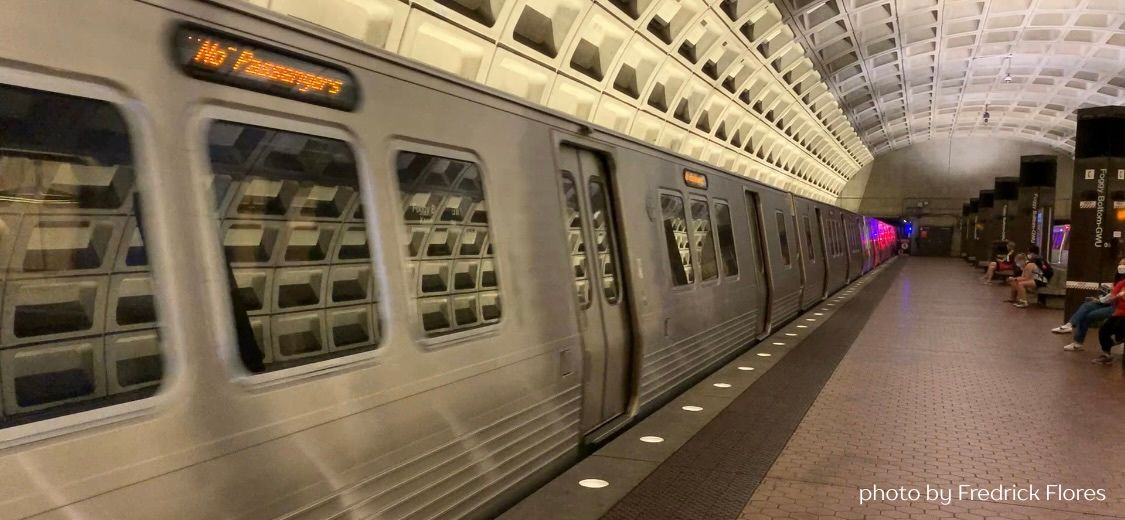

# Crafting Fictional Regional Transit Data

Prepared by: Fredrick Flores

Creating fictional data can be a powerful tool for local developers, urban planners, data scientists, and transit enthusiasts when they want to avoid using real data sets, perhaps for privacy reasons, or if you want to perform tests on algorithms with tailor-made data. This notebook demonstrates how I typically create fictional data in the context of urban development and planning.

**How I Anticipate Using This Data**

Since my career orients around city work, I thought it would be helpful to develop examples of transit data. We will explore how to generate synthetic transit data using Python - including categorical `account_type`, ordinal `dis_grp_type`, multi-modal continuous `avg_trip_dis`, and Boolean `survey_opt_in` data types.

**How Others Can Use This Data**

By simulating realistic yet fictional transit systems, others can use this data for building and testing transit apps, training machine learning models, or running simulations. Further, one can use the following code for inspiration for creating different types of fictional data.

Whether you are working on a side project, teaching a course, or developing a new project, synthetic transit data can offer a flexible and risk-free foundation to build upon. Let's dive into how Python can help bring this data to life!

In [ ]:
# Standard Imports
!pip install faker

import numpy as np
from faker import Faker
import pandas as pd

import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler

# Overview of Fictional Data

The following types of data are often useful knowledge for transit projects, which is why I chose to create fictional versions of them in this dataset.

* `account_type` - Categorical/ Nominal. Type of account. e.g. `Regular`, `Student`, `Senior`, `Disability`, `Low Income`, `Tourist`.
* `passenger_id` - Nominal. Unique ID for each rider. Having unique IDs is especially helpful if there are multiple passengers with the same first and last names.
* `fare_plan` - Categorical/ Nominal. Type of fare plan. e.g. `Single Ride`, `Weekly Pass`, `Monthly Pass`, `Pay As You Go`.
* `preferred_payment` - Categorical/ Nominal. Method passenger prefers to pay with. e.g. `Mobile App`, `Smartcard`, `Cash`, `Bank Transfer`.
* `passenger_name` - Nominal. Passenger Name.
* `survey_opt_in` - Boolean. Whether the rider has opted into user surveys.
* `avg_trip_dis` - Continuous. Average distance per ride based on trip history.
* `dis_grp_type` - Categorical/ Ordinal. Category of how much average distance per ride for a passenger based on a scale. e.g. `low`, `medium`, `high`.
* `last_active_date` - Datetime. Last ride or transaction.
* `total_trips_year` - Discrete/ Integer. Total Trips in a Year per passenger.
* `avg_commute_week` - Discrete/ Integer. Average Trips in a Week per passenger.
* `account_creation` - Datetime. Account Creation Date.
* `account_age` - Datetime. Age of account in days from creation to last use.
* `'eligible_discount` - Boolean. Whether the account is eligible for a discount. `Student`, `Senior`, `Disability`, and `Low Income` accounts are eligible for a discount. `Tourist`and `Regular` accounts are not.

# Creating The Data Set

I use each step to build the Fictional Regional Transit Data with help from the libraries defined above.


## Step 1: Instantiate Faker and specified number of records

In [ ]:
# Instantiate a Faker() object
fake = Faker()

#Specify the number of records to create
num_records = 1000

## Step 2: Prepare Selected Features

### Step 2a: Creating the multi-modal `Average trip Distance (Miles)` variable using make_blobs

A multi-modal distribution allows the distances to center on three different distances. Perhaps it is common for passengers to frequently travel around those three specific distances based on common travel behavior, and they can be categorized as "low", "medium", or "high" travel distances. We make the assumption here that passengers tend to travel anywhere between 1.5 miles to 27 miles.

In [ ]:
avg_distance, dis_group = make_blobs(n_samples = 1000, n_features = 1, centers = 3, random_state= 1)

# Instantiate appropriate scalers
distance_scale = MinMaxScaler((1.5, 27))

#Scale the data
avg_distance = distance_scale.fit_transform(avg_distance)

### Step 2b: Creating datetime data and mapping discounts

When creating datetime data, we make the assumption that passengers last used transit anytime within the past 30 days and created their accounts anytime within the past year.

We also use the mapping function to appropriately assign discounts to the right account types.

In [ ]:
# Datetime data
account_creation = [fake.date_time_between(start_date='-3y', end_date='now') for _ in range(num_records)]

last_active_date = [fake.date_time_between(start_date='-30d', end_date='now') for _ in range(num_records)]

account_age = [x - y for x,y in zip(last_active_date, account_creation)]

# Mapping discount data

discount_mapping = {"Regular": False, "Student": True, "Senior": True, "Disability": True, "Low Income": True, "Tourist": False}
account_type = np.random.choice(
        ["Regular", "Student", "Senior", "Disability", "Low Income", "Tourist"],
        num_records)

### Step 2c: Formulating Total Trips in a Year data

Sometimes we want to create some normailty in our continuous data. To do so, we use `pd.Series`. We can confirm the results using `sns.histplot`

<Axes: ylabel='Count'>

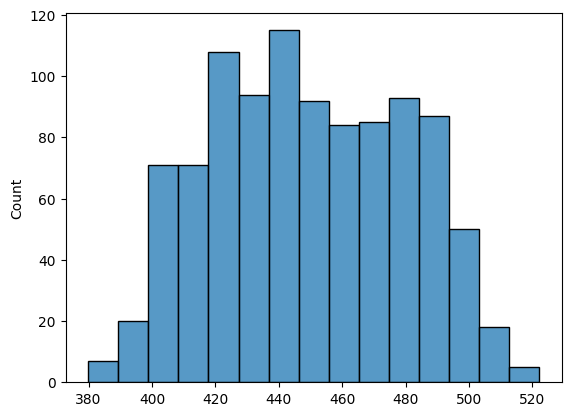

In [ ]:
# Prepare selected features

annual_count_of_trips = pd.Series(np.random.randint(400, 500, num_records) +
                                  np.random.normal(0, 10, num_records))

sns.histplot(annual_count_of_trips)

Not only do we want to create normality, but perhaps we also want to artificially make annual count of trips an imperfect function of `avg_distance`

<Axes: ylabel='Count'>

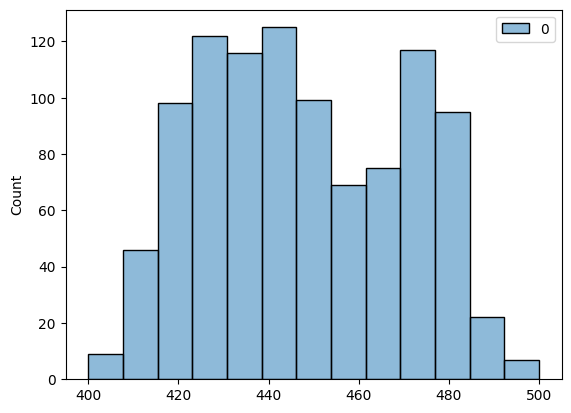

In [ ]:
# Make annual count of trips an imperfect function of avg_distance with some noise
annual_count_of_trips = avg_distance.reshape(-1,)+ np.random.normal(0, 3, num_records).reshape(-1,)

# Create a scaler for annual count of trips
annual_count_scaler = MinMaxScaler((400, 500))

# Rescale avg_trip distance to an int between 400 and 500
annual_count_of_trips = annual_count_scaler.fit_transform(annual_count_of_trips.reshape(-1,1))

# Reverse scale annual_count_of_trips (to make negative correlation)
annual_count_of_trips = ((annual_count_of_trips - annual_count_of_trips.max())* -1) + 400

sns.histplot(annual_count_of_trips)

In [ ]:
# Double check to see if results are negative correlation (Farther trips result in less frequent trips)

pd.DataFrame({"trips": annual_count_of_trips.reshape(-1,), "distance": avg_distance.reshape(-1,)}).corr()

,trips,distance
trips,1.000000,-0.926863
distance,-0.926863,1.000000


## Step 3: Putting together and creating rest of dataset

In [ ]:
df = pd.DataFrame({

    # Passenger ids
    'passenger_id': 100000 + np.arange(1, num_records + 1),

    # Account types
    'account_type': account_type,

    # Eligible for Discount
    'eligible_discount': [discount_mapping[id] for id in account_type],

    # Fare plan type
    'fare_plan': np.random.choice(
        ['Single Ride', 'Weekly Pass', 'Monthly Pass', 'Pay As You Go'],
        num_records),

    # Preferred payment
    'preferred_payment': np.random.choice(
        ['Mobile App', 'Smartcard', 'Cash', 'Bank Transfer'],
        num_records),

    # Generate names and leaving 20% of the data to be unknown for this variable.
    # I leave unknown data since real-world data often present missing data, or maybe a passenger wants to be anonymous.

    'passenger_name': [fake.name() if np.random.rand() > 0.2
                       else 'Unknown' for _ in range(num_records)],

    # Wheter the rider opted into user surveys
    'survey_opt_in': np.random.choice(
        [True, False], num_records),

    # Average Trip Distance (Miles)
    'avg_trip_dis': avg_distance.reshape(-1,),

    # Distance Group Type
    'dis_grp_type': dis_group,

    # Last ride or transaction data
    'last_active_date': last_active_date,

    # Total Trips in a Year
    'total_trips_year': annual_count_of_trips.reshape(-1,),

    # Average Trips in a Week
    'avg_commute_week': (annual_count_of_trips / 52).reshape(-1,),

    # Account Creation Date
    'account_creation': account_creation,

    # Account Age
    'account_age': account_age

})

#Renaming distance travelled group type

df['dis_grp_type'] = df['dis_grp_type'].map({2 : 'low', 0 : 'medium', 1 : 'high'})

## Step 4: Inspecting Results

Now that we have our fictional data in a dataframe, let's inspect the results!

In [ ]:
# Review the summary statistics

df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
passenger_id,1000.0,100500.5,100001.0,100250.75,100500.5,100750.25,101000.0,288.819436
avg_trip_dis,1000.0,14.287631,1.5,5.725547,15.299451,21.794223,27.0,7.338827
last_active_date,1000,2025-06-05 20:56:50.730001664,2025-05-21 21:30:19.785248,2025-05-29 11:31:40.708682496,2025-06-06 06:24:19.418921472,2025-06-13 05:26:59.254362880,2025-06-20 17:43:17.125444,NaN
total_trips_year,1000.0,447.651341,400.0,429.10759,444.978112,468.414833,500.0,22.231635
avg_commute_week,1000.0,8.60868,7.692308,8.252069,8.557271,9.007978,9.615385,0.427531
account_creation,1000,2023-12-25 00:16:20.779559936,2022-06-23 10:30:41.942175,2023-03-31 10:55:55.409958656,2023-12-28 10:53:40.558049024,2024-09-23 17:32:21.441736960,2025-06-20 07:41:54.696291,NaN
account_age,1000,528 days 20:40:29.950441944,-14 days +05:28:47.800677,256 days 08:06:01.884768248,527 days 01:43:00.092177,794 days 16:59:09.615402752,1093 days 01:01:02.341459,311 days 22:02:18.430002812


In [ ]:
# Inspect sample of dataframe

df.sample(4)

,passenger_id,account_type,eligible_discount,fare_plan,preferred_payment,passenger_name,survey_opt_in,avg_trip_dis,dis_grp_type,last_active_date,total_trips_year,avg_commute_week,account_creation,account_age
663,100664,Regular,False,Weekly Pass,Mobile App,Unknown,False,15.670343,medium,2025-05-30 21:26:09.723122,438.780718,8.438091,2024-06-22 19:14:34.462274,342 days 02:11:35.260848
581,100582,Regular,False,Pay As You Go,Bank Transfer,Dr. Ryan Rose MD,True,22.324058,high,2025-06-01 08:26:06.177647,428.845790,8.247034,2024-11-07 22:26:21.687906,205 days 09:59:44.489741
655,100656,Student,True,Single Ride,Cash,Unknown,False,2.630921,low,2025-06-07 22:21:28.156832,484.307494,9.313606,2024-11-23 18:04:40.672355,196 days 04:16:47.484477
669,100670,Senior,True,Pay As You Go,Mobile App,Alexis Nixon,False,5.844962,low,2025-05-26 15:11:26.698505,479.813386,9.227180,2022-08-24 11:31:40.464730,1006 days 03:39:46.233775


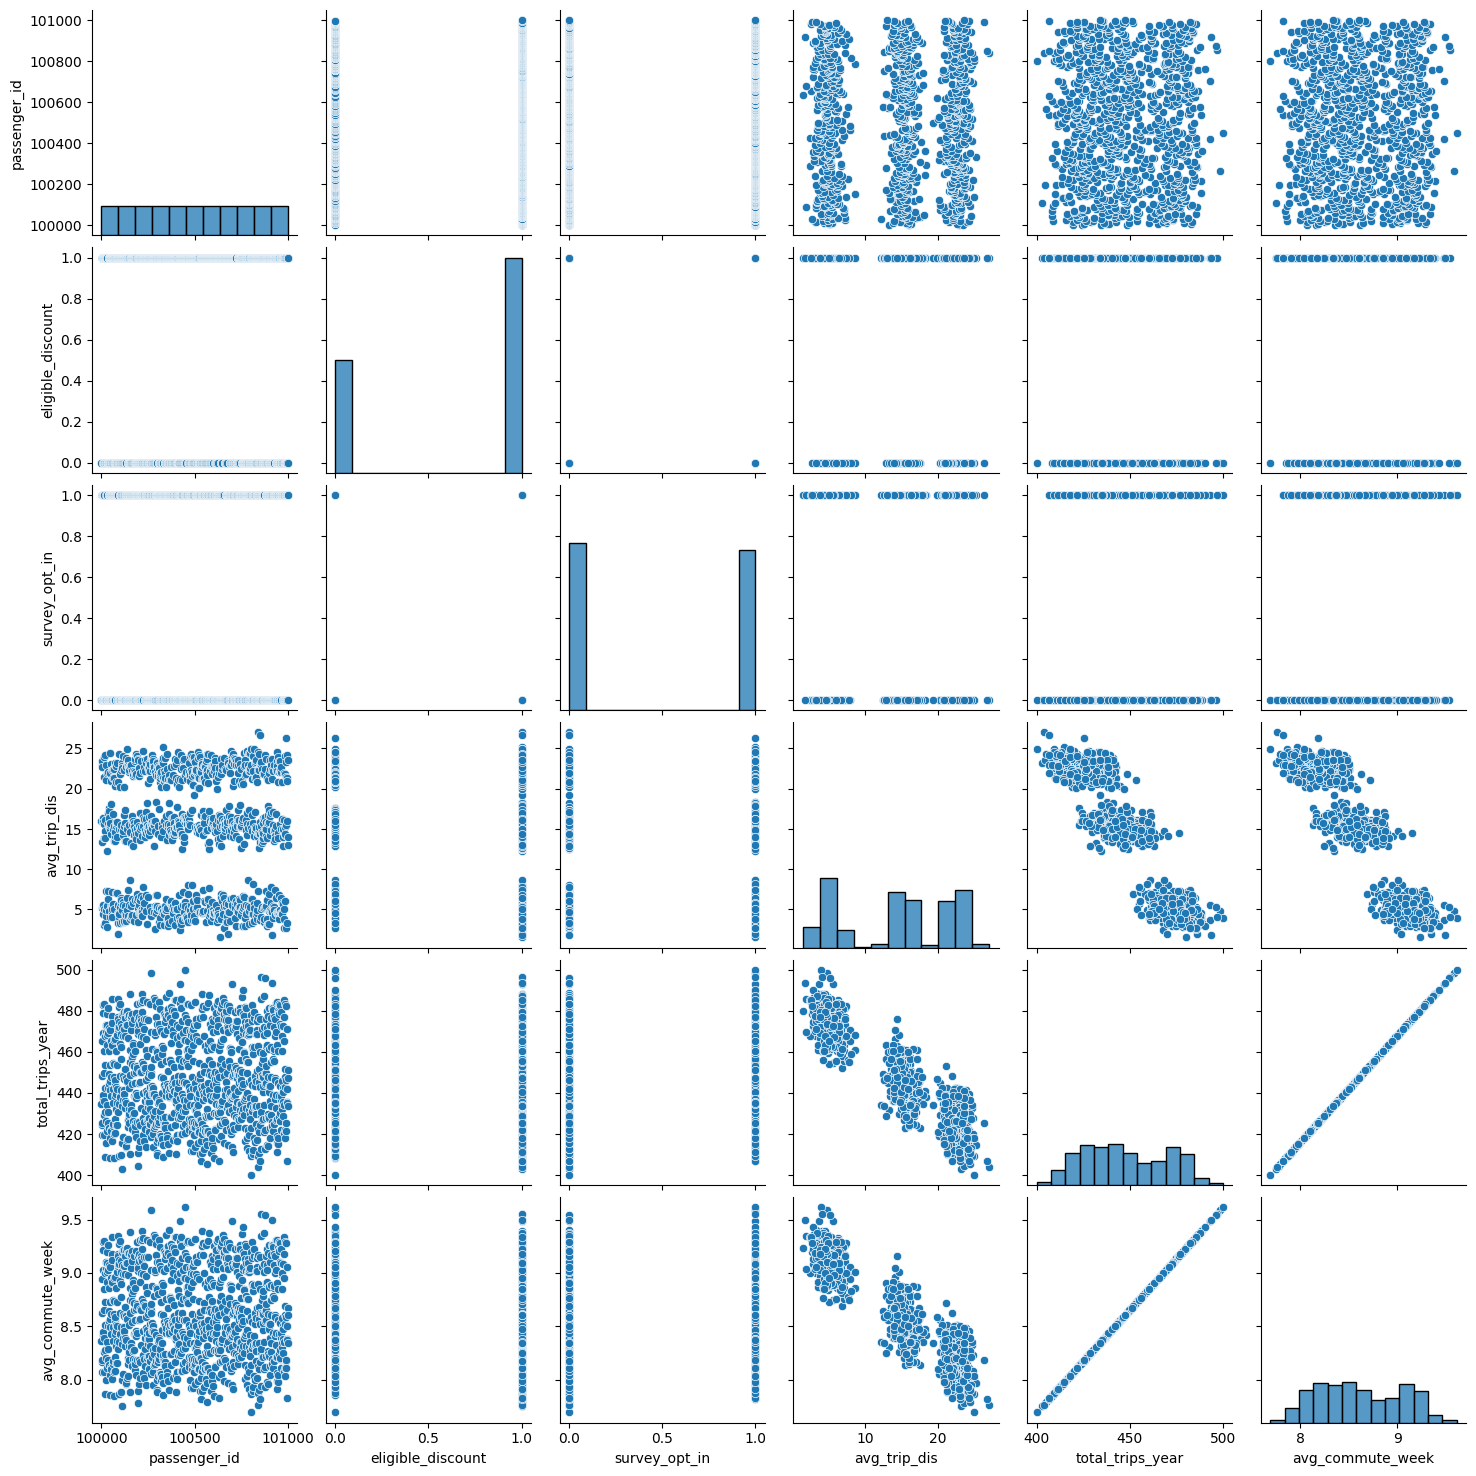

In [ ]:
# Selected visuals

sns.pairplot(df)

<Axes: xlabel='total_trips_year', ylabel='avg_trip_dis'>

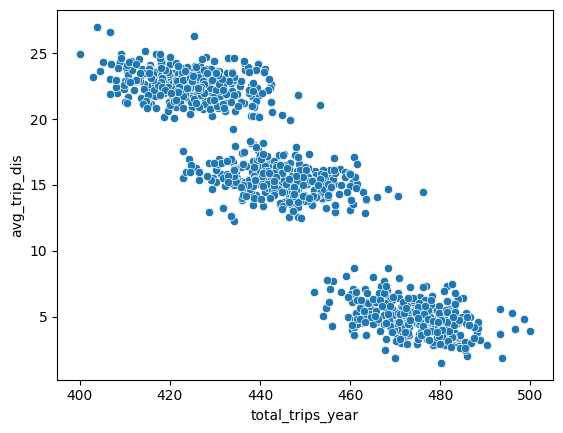

In [ ]:
# Did we artifically create correlation between `total_trips_year` and `avg_trip_dis`?

sns.scatterplot(data = df, x = 'total_trips_year', y = 'avg_trip_dis')

# The answer is yes.

# Conclusion

Now we have our Fictional Regional Transit Data!


Creating fictional transit data with Python offers a powerful way to simulate real-world transportation systems for testing, analysis, or demonstration purposes. By leveraging libraries, such as `pandas`, `numpy`, `faker`, and `sklearn.datasets`, we can efficiently generate realistic rider patterns that mirror actual transit behaviors. Whether you are developing a prototype application or teaching data science, fictional data can provide a risk-free, flexible foundation.

\
Good luck crafting your own fictional data!